In [1]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import FunctionTransformer as FT
from sklearn.impute import SimpleImputer

from lib.Extractor import FeatureExtractor
from lib.Models import FullyConnectedNetworkClassifier
from lib.Datasets import TabularDataset
from lib.Transformers import NumericalTransformer, CategoricalTransformer, CategoricalTargetTransformer, DatasetTransformer

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

##### Reproducibility

In [2]:
torch.manual_seed(0)
np.random.seed(0)

### Dataset's

In [3]:
train_df = pd.read_csv('csv/_train_2020_09_13.csv', low_memory=False)
print('{0:,} registros a las {1}'.format(len(train_df), datetime.now()))
train_df.head()

144,995 registros a las 2020-09-18 22:56:06.004149


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días


In [4]:
validation_df = pd.read_csv('csv/_validation_2020_09_13.csv', low_memory=False)
print('{0:,} registros a las {1}'.format(len(validation_df), datetime.now()))
validation_df.head()

35,766 registros a las 2020-09-18 22:56:06.455178


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,6,280.245759,508.898157,19880.954667,3.340348,7.337031,8.120307,0.001,False,...,8599.0,18979.0,120.0,9517.0,1919367,19627,375891,7a81b3dc-0f1d-47b9-9ebe-6b080f0f9a78,43543000.0,GARANTIA DEL FABRICANTE 12 MESES
1,True,44,114.704700,200.589045,2239.911000,4.387991,2.588060,3.023881,0.001,False,...,867.0,5279.0,4.0,1013.0,336447,243,202158,ede61a11-5ef8-4626-86d0-2040abcb15d3,NaN,NaN
2,True,163,69.938155,120.521127,4917.262000,2.836291,4.301471,7.982026,0.001,False,...,5265.0,16769.0,90.0,9770.0,293809,1514,134501,37695e18-617e-4977-9d8d-25b963bcbfda,158491483.0,Garantía del vendedor: 15 días
3,True,99980,61.344055,43.361379,335.328000,5.504259,5.172414,12.599138,0.001,False,...,1200.0,8458.0,18.0,2923.0,98151,207,81713,6177b855-73f4-454b-92a6-84ab2870ba56,195821718.0,Garantía del vendedor: 180 días
4,True,3741,275.396775,5019.725800,8366.209667,3.506554,124.760000,139.820000,0.001,False,...,6238.0,15074.0,219.0,6991.0,1612203,21461,503854,b80c6195-ae11-4980-81a2-0b6af863abd3,322103542.0,Garantía del vendedor: 6 meses


### Test set

In [5]:
test_df = pd.read_csv('csv/test.csv', sep=',', low_memory=False)
print('{0:,} registros a las {1}'.format(len(test_df), datetime.now()))
test_df.head()

19,211 registros a las 2020-09-18 22:56:06.656304


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,4,98.426510,91.979648,3657.724000,3.589443,3.461023,4.988265,0.001,False,...,1364.0,18.0,5951.0,40954,300,100477,703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7,233223201.0,Garantia de fabrica,0
1,True,12,242.485208,821.376944,985.652333,3.215580,26.222222,28.388889,0.001,False,...,3724.0,41.0,1022.0,135133,926,44033,d714e65e-5447-4f7d-9a4e-aaa57efa6107,337881137.0,NaN,1
2,True,5,2450.533424,1365.504354,33454.856667,7.097276,14.646259,15.217687,0.001,False,...,1839.0,71.0,11185.0,204788,8457,716157,299cb623-b71c-4f9d-b792-48d5744f0449,86609353.0,Garantía de fábrica: 12 meses,2
3,True,9052,157.735448,78.692131,160.007333,4.927390,2.983607,3.524590,0.001,False,...,85528.0,44.0,215.0,1404477,1907,6580,f2060244-f0da-43db-91b7-4c1bb5f99e67,430797570.0,Sin garantía,3
4,True,37,116.891454,163.245653,4043.050667,2.937837,7.257066,19.771198,0.001,False,...,61466.0,274.0,14690.0,1466424,2633,215184,d7f3b7f4-a9fa-4bd8-a600-3f2714480779,6566243.0,Garantía de fábrica: 6 meses,4


#### To dictionaries

In [6]:
X_train = train_df.to_dict('records')
X_validation = validation_df.to_dict('records')
X_test = test_df.to_dict('records')

Y_train = train_df['conversion'].values
Y_validation = validation_df['conversion'].values

In [7]:
str(np.nan)

'nan'

### Transformations

#### Functions

In [8]:
def get_day_of_week(feature:np.ndarray) -> np.ndarray:
    dates = [datetime.strptime(str_date[:10], '%Y-%m-%d') for str_date in feature]
    return np.array([dt.weekday() for dt in dates])

def is_weekend(feature:np.ndarray) -> np.ndarray:
    dates = [datetime.strptime(str_date[:10], '%Y-%m-%d') for str_date in feature]
    return np.array([False if dt.weekday() >= 0 and dt.weekday() <= 4 else True for dt in dates])

def get_hour(feature:np.ndarray) -> np.ndarray:
    #dates = [datetime.strptime(str_date[:10], '%Y-%m-%d') for str_date in feature]
    return np.array([int(str_date[11:13]) for str_date in feature])

def has_tag(feature:np.ndarray, tag:str) -> np.ndarray:
    return np.array([True if tag in item else False for item in feature])

def is_loggued(feature:np.ndarray) -> np.ndarray:
    return np.array([True if item != 'nan' else False for item in feature])

def transform_tags(feature:np.ndarray) -> np.ndarray:
    tms_1 = [value[1:-1] for value in feature]
    tms_2 = [sorted(value.split(', ')) for value in tms_1]
    return np.array([' '.join(value) for value in tms_2])

In [9]:
dataset_tranformer = DatasetTransformer([
    # Categorical features - Boolean
    ('free_shipping', CategoricalTransformer('free_shipping')),
    ('is_pdp', CategoricalTransformer('is_pdp')),
    # Categorical features
    ('category_id', CategoricalTransformer('category_id')),
    #('deal_print_id', CategoricalTransformer('deal_print_id')),
    ('domain_id', CategoricalTransformer('domain_id')),
    ('product_id', CategoricalTransformer('product_id')),
    ('item_id', CategoricalTransformer('item_id')),
    ('listing_type_id', CategoricalTransformer('listing_type_id')),
    ('logistic_type', CategoricalTransformer('logistic_type')),
    ('platform', CategoricalTransformer('platform')),
    #('tags', CategoricalTransformer(feature='tags', pre_tms=[FT(transform_tags)])),
    ('has_good_quality_picture', CategoricalTransformer(feature='tags', pre_tms=[FT(has_tag, kw_args={'tag':'good_quality_picture'})])),
    ('has_good_quality_thumbnail', CategoricalTransformer(feature='tags', pre_tms=[FT(has_tag, kw_args={'tag':'good_quality_thumbnail'})])),
    ('has_brand_verified', CategoricalTransformer(feature='tags', pre_tms=[FT(has_tag, kw_args={'tag':'brand_verified'})])),
    ('has_ahora_12', CategoricalTransformer(feature='tags', pre_tms=[FT(has_tag, kw_args={'tag':'ahora-12'})])),
    ('has_loyalty_discount_eligible', CategoricalTransformer(feature='tags', pre_tms=[FT(has_tag, kw_args={'tag':'loyalty_discount_eligible'})])),
    ('has_today_promotion', CategoricalTransformer(feature='tags', pre_tms=[FT(has_tag, kw_args={'tag':'today_promotion'})])),
    #('uid', CategoricalTransformer('uid')),
    ('is_loggued_user', CategoricalTransformer(feature='user_id', pre_tms=[FT(is_loggued)])),
    ('offset', CategoricalTransformer('offset')),
    ('print_position', CategoricalTransformer('print_position')),
    # Categorical Features extracted from "print_server_timestamp"
    ('day_of_week', CategoricalTransformer(feature='print_server_timestamp', pre_tms=[FT(get_day_of_week)])),
    ('hour', CategoricalTransformer(feature='print_server_timestamp', pre_tms=[FT(get_hour)])),
    ('is_weekend', CategoricalTransformer(feature='print_server_timestamp', pre_tms=[FT(is_weekend)])),
    
    # Numerical features
    ('price', NumericalTransformer('price')),
    ('available_quantity', NumericalTransformer('available_quantity')),
    ('health', NumericalTransformer('health')),
    ('sold_quantity', NumericalTransformer('sold_quantity')),
    ('qty_items_sel', NumericalTransformer('qty_items_sel')),
    ('total_visits_seller', NumericalTransformer('total_visits_seller')),
    ('total_visits_item', NumericalTransformer('total_visits_item')),
    ('total_gmv_item_30days', NumericalTransformer('total_gmv_item_30days', imputer=SimpleImputer(strategy='constant', fill_value=0)))
])

target_transformer = CategoricalTargetTransformer('conversion')

In [10]:
"""
    ('avg_gmv_item_sel', NumericalTransformer('avg_gmv_item_sel', imputer=SimpleImputer(strategy='constant', fill_value=0))),
    ('avg_qty_orders_item_domain_30days', NumericalTransformer('avg_qty_orders_item_domain_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),
    ('avg_qty_orders_item_sel_30days', NumericalTransformer('avg_qty_orders_item_sel_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),
    ('total_asp_item_domain_30days', NumericalTransformer('total_asp_item_domain_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),
    ('total_asp_item_sel_30days', NumericalTransformer('total_asp_item_sel_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),
    ('total_gmv_domain_bday', NumericalTransformer('total_gmv_domain_bday', imputer=SimpleImputer(strategy='constant', fill_value=0))),
    ('total_gmv_item_30days', NumericalTransformer('total_gmv_item_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),
    ('total_items_seller', NumericalTransformer('total_items_seller', imputer=SimpleImputer(strategy='constant', fill_value=0))),
    ('total_orders_domain_30days', NumericalTransformer('total_orders_domain_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),
    ('total_orders_item_30days', NumericalTransformer('total_orders_item_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),
    ('total_orders_sel_30days', NumericalTransformer('total_orders_sel_30days', imputer=SimpleImputer(strategy='constant', fill_value=0)))
"""

"\n    ('avg_gmv_item_sel', NumericalTransformer('avg_gmv_item_sel', imputer=SimpleImputer(strategy='constant', fill_value=0))),\n    ('avg_qty_orders_item_domain_30days', NumericalTransformer('avg_qty_orders_item_domain_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),\n    ('avg_qty_orders_item_sel_30days', NumericalTransformer('avg_qty_orders_item_sel_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),\n    ('total_asp_item_domain_30days', NumericalTransformer('total_asp_item_domain_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),\n    ('total_asp_item_sel_30days', NumericalTransformer('total_asp_item_sel_30days', imputer=SimpleImputer(strategy='constant', fill_value=0))),\n    ('total_gmv_domain_bday', NumericalTransformer('total_gmv_domain_bday', imputer=SimpleImputer(strategy='constant', fill_value=0))),\n    ('total_gmv_item_30days', NumericalTransformer('total_gmv_item_30days', imputer=SimpleImputer(strategy='constant', fi

In [11]:
%%time
numerical_features_train, categorical_features_train = dataset_tranformer.fit_transform(X_train)
target_train = target_transformer.fit_transform(Y_train)

CPU times: user 7.59 s, sys: 437 ms, total: 8.03 s
Wall time: 8.06 s


In [12]:
numerical_features_train.shape, categorical_features_train.shape, target_train.shape

((144995, 8), (144995, 21), (144995, 1))

In [13]:
i,_,_ = dataset_tranformer.get('is_loggued_user')
np.unique(categorical_features_train[:,i], return_counts=True)

(array([0, 1]), array([ 15731, 129264]))

In [14]:
%%time
numerical_features_validation, categorical_features_validation = dataset_tranformer.transform(X_validation)
target_validation = target_transformer.transform(Y_validation)

CPU times: user 31 s, sys: 218 ms, total: 31.2 s
Wall time: 31.2 s


In [15]:
numerical_features_validation.shape, categorical_features_validation.shape, target_validation.shape

((35766, 8), (35766, 21), (35766, 1))

In [16]:
%%time
numerical_features_test, categorical_features_test = dataset_tranformer.transform(X_test)

CPU times: user 17.1 s, sys: 116 ms, total: 17.2 s
Wall time: 17.2 s


In [17]:
numerical_features_test.shape, categorical_features_test.shape

((19211, 8), (19211, 21))

In [18]:
i,_,_ = dataset_tranformer.get('has_good_quality_picture')
np.unique(categorical_features_test[:,i])

array([0, 1])

### Datasets and Dataloaders

In [19]:
train_ds = TabularDataset(numerical_features_train, categorical_features_train, target_train)
validation_ds = TabularDataset(numerical_features_validation, categorical_features_validation, target_validation)
test_ds = TabularDataset(numerical_features_test, categorical_features_test)

In [20]:
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)

train_dl_for_prediction = DataLoader(train_ds, batch_size=1024, shuffle=False)
validation_dl = DataLoader(validation_ds, batch_size=1024, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1024, shuffle=False)

### Training the network

In [21]:
embedding_dims = dataset_tranformer.get_embeddings_size()
numerical_features_quantity, categorical_features_quantity = dataset_tranformer.get_features_quantity()

In [22]:
model = FullyConnectedNetworkClassifier(
    q_numerical_features = numerical_features_quantity, 
    q_categorical_features = categorical_features_quantity,
    hidden_layers_size=[512,256,64],
    embedding_dims=embedding_dims
)
optimizer = Adam(model.parameters(), lr=1e-1, weight_decay=0.01)
lr_scheduler = ExponentialLR(optimizer=optimizer, gamma=0.98)
bceloss_fn = nn.BCELoss(reduction='mean')
epochs=3

In [23]:
model

FullyConnectedNetworkClassifier(
  (embeddings_layer): ModuleList(
    (0): Embedding(3, 1)
    (1): Embedding(4, 2)
    (2): Embedding(2047, 50)
    (3): Embedding(1587, 50)
    (4): Embedding(3412, 50)
    (5): Embedding(19942, 50)
    (6): Embedding(3, 1)
    (7): Embedding(8, 4)
    (8): Embedding(5, 2)
    (9): Embedding(3, 1)
    (10): Embedding(3, 1)
    (11): Embedding(3, 1)
    (12): Embedding(3, 1)
    (13): Embedding(3, 1)
    (14): Embedding(3, 1)
    (15): Embedding(3, 1)
    (16): Embedding(207, 50)
    (17): Embedding(9961, 50)
    (18): Embedding(8, 4)
    (19): Embedding(25, 12)
    (20): Embedding(3, 1)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (layer_0): Sequential(
    (0): Linear(in_features=342, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_1): Sequential(
    (0): Linear(in_features=512, out_features=256, bi

In [24]:
%%time
losses = model.fit(train_dl=train_dl, epochs=epochs, loss_fn=bceloss_fn, opt=optimizer, scheduler=lr_scheduler)

CPU times: user 3min 20s, sys: 6.66 s, total: 3min 26s
Wall time: 52 s


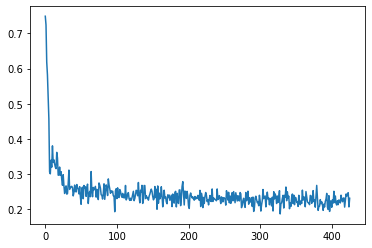

In [25]:
plt.plot(range(len(losses)), losses)

### Validating the net

In [26]:
x_numerical_train, x_categorical_train, y_train = train_ds.reverse_transform()

In [27]:
x_numerical_val, x_categorical_val, y_val = validation_ds.reverse_transform()

In [28]:
x_numerical_test, x_categorical_test, _ = test_ds.reverse_transform()

In [29]:
y_train_pred = model.predict(train_dl_for_prediction).numpy().squeeze()

In [30]:
y_val_pred = model.predict(validation_dl).numpy().squeeze()

In [31]:
y_test_pred = model.predict(test_dl).numpy().squeeze()

#### Training

In [32]:
aucroc_train = roc_auc_score(y_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.8865297436885218


In [33]:
accuracy_train = accuracy_score(y_train, [1 if pred >= .5 else 0 for pred in y_train_pred])
print(f'Accuracy in training: {accuracy_train}')

Accuracy in training: 0.9098520638642712


#### Validation

In [34]:
aucroc_val = roc_auc_score(y_val, y_val_pred)
print(f'Auc Roc in test: {aucroc_val}')

Auc Roc in test: 0.8735923051414695


In [35]:
accuracy_val = accuracy_score(y_val, [1 if pred >= .5 else 0 for pred in y_val_pred])
print(f'Accuracy in test: {accuracy_val}')

Accuracy in test: 0.9027568081418107


#### Testing submission

In [36]:
submission = pd.DataFrame({
    'conversion': y_test_pred
}).reset_index().rename({'index':'ROW_ID'}, axis=1)
submission['conversion'] = np.round(submission['conversion'], 4)
submission.tail()

,ROW_ID,conversion
19206,19206,0.0747
19207,19207,0.1220
19208,19208,0.0224
19209,19209,0.0621
19210,19210,0.0207


In [37]:
submission.to_csv('submission_2020_09_18.csv.gz', compression='gzip', index=False)